# Preprocessing
<font color=red> Key Assumption: </font>
- In this period, the preference of user will not change
- The order only happen in the same day as request
    - It could be released later if we want to generate more samples
- In all the n-grams samples (user request sku list), choose window_size = 5, predict the middle one which is ordered sku_id

In [1]:
# -*- coding: utf-8 -*-



PATH_CLICK = './data/JD_click_data.csv'
PATH_USER = './data/JD_user_data.csv'
PATH_SKU = './data/JD_sku_data.csv'
PATH_ORDER = './data/JD_order_data.csv'


# =============================================================================
# Function to load data
# =============================================================================


def load_click(PATH_CLICK=PATH_CLICK, 
               sort=['user_ID', 'request_time'],
                num_samples=None):
    '''
    load click table
    
    input: 
        sort: list of column names that you want to sort
    output:
        DataFrame object of click table
    
    >>> load_click(sort=['user_ID', 'request_time'])
    '''
    df = read_csv(PATH_CLICK, nrows=num_samples)
    # df.columns
    df = ts_attrs_add(df, ts_col = 'request_time') # to datatime, and split the datatime col into several cols, like month day year etc
    
    if sort:
        df.sort_values(sort, inplace=True)
#     if frequency == 'd':
#         df['request_date'] = df['request_time'].apply(
#                 lambda x: datetime(x.year, x.month, x.day))
    return df[df['user_ID']!='-'] # delete "-" user


def load_user(PATH_USER=PATH_USER):
    return read_csv(PATH_USER)


def load_sku(PATH_SKU=PATH_SKU):
    return read_csv(PATH_SKU)


def load_order(PATH_ORDER=PATH_ORDER, num_samples=None):
    df = read_csv(PATH_ORDER, nrows=num_samples)
    # df.columns
    df = ts_attrs_add(df, ts_col = 'order_time')
    return df

# -*- coding: utf-8 -*-
# from dataset import load_dataset
import sys
# sys.path.append('../')




# add time related cols
import pandas as pd
from sklearn import preprocessing
from pandas import read_csv, datetime, to_datetime
from tqdm import tqdm
tqdm.pandas(desc='pandas bar')
import time
def ts_str2sec(format_time):
    '''
    input: format_time = "2018-03-01 13:21:04"
    output: timeStamp = 1381419600
    '''
    ts = time.strptime(format_time, "%Y-%m-%d %H:%M:%S")
    return time.mktime(ts)  

def ts_sec2str(timeStamp):
    '''
    input:  timeStamp = 1381419600
    output: format_time = "2018-03-01 13:21:04"
    '''
    return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timeStamp))

def ts_attrs_add(df, ts_col = 'request_time'):
    # num_samples=10000
    # ######### generate request_date
    # df = read_csv(PATH_CLICK, nrows=num_samples)
    # ts_col = 'request_time'
    df[ts_col] = to_datetime(df[ts_col])
    df[ts_col+'_sec'] = df[ts_col].astype(str).progress_apply(ts_str2sec)
    
    # For visulization
    df['hour'] = df[ts_col].dt.hour
    df['day'] = df[ts_col].dt.day
    df['month'] = df[ts_col].dt.month
    df['year'] = df[ts_col].dt.year
    df['daysinmonth'] = df[ts_col].dt.daysinmonth
    df['dayofyear'] = df[ts_col].dt.dayofyear 
    
    # year-month-day
    df[ts_col[0:-4]+'date'] = df[ts_col].dt.date
    
    return df

# testing
b = load_click(num_samples=1000)
b.head()

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
pandas bar: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 62489.63it/s]


,sku_ID,user_ID,request_time,channel,request_time_sec,hour,day,month,year,daysinmonth,dayofyear,request_date
261,93e45f6367,00ada018b8,2018-03-01 10:55:05,wechat,1.519920e+09,10,1,3,2018,31,60,2018-03-01
106,0c9a9ae0be,01794bf7c5,2018-03-01 23:57:50,wechat,1.519967e+09,23,1,3,2018,31,60,2018-03-01
105,0c9a9ae0be,01794bf7c5,2018-03-01 23:58:02,wechat,1.519967e+09,23,1,3,2018,31,60,2018-03-01
108,0c9a9ae0be,01794bf7c5,2018-03-01 23:58:07,wechat,1.519967e+09,23,1,3,2018,31,60,2018-03-01
107,0c9a9ae0be,01794bf7c5,2018-03-01 23:58:34,wechat,1.519967e+09,23,1,3,2018,31,60,2018-03-01


## load click and user table 
- Time attrs added
- label encoding for "sku_ID", "user_ID", "order_ID" and perserve the original one for final evaluate

In [2]:
def load_click_order(click_cols = ['user_ID', 'sku_ID',  'day', 'month', 'year', 'hour','request_time_sec'],
                     order_cols = ['user_ID', 'sku_ID',  'day', 'month', 'year', 'hour', 'order_ID', 'order_time_sec'],
                     sku_cols = ['sku_ID', 'type', 'brand_ID'],
                     sort = ['user_ID', 'request_time_sec'], num_samples=None, label_encode=True, load=True, file_version='test'):
    '''
    
    1. 读取4个表
    2. 添加时间属性3列 (day month year) etc
    3. label encoding (user_ID, sku_ID). origin ID 保存在user_table 和sku_table
    4. outer join table (因为暂时还不确定是在一天内. 如果确定在一天内 request链接 并下单, 则用left join)
        - 例如:  左侧为空, 右侧有的, 就是可能在前些天 有request, 然后过了几天才下单. 这个问题需要通过 request_time_sec 来做差解决
    5. 返回df (做EDA的数据已经另存, 此处不需要返回 order_table 和 click_table)
    
    click_table.columns = ['sku_ID', 'user_ID', 'request_time', 'channel', 'request_time_sec',
           'hour', 'day', 'month', 'year', 'daysinmonth', 'dayofyear',
           'request_date']     

    order_table.columns = ['order_ID', 'user_ID', 'sku_ID', 'order_date', 'order_time', 'quantity',
           'type', 'promise', 'original_unit_price', 'final_unit_price',
           'direct_discount_per_unit', 'quantity_discount_per_unit',
           'bundle_discount_per_unit', 'coupon_discount_per_unit', 'gift_item',
           'dc_ori', 'dc_des', 'order_time_sec', 'hour', 'day', 'month', 'year',
           'daysinmonth', 'dayofyear']
    
    sku_table.columns = ['sku_ID', 'type', 'brand_ID', 'attribute1', 'attribute2',
           'activate_date', 'deactivate_date', 'origin_sku_ID']
    '''
#     click_table = load_dataset.load_click(sort=None)[cols1]
#     order_table = load_dataset.load_order()[cols2]
#     click_table = load_click(sort=None, num_samples=num_samples)[click_cols1] # 已去除 "-" 用户
#     order_table = load_order(num_samples=num_samples)[order_cols2]

    if load is True:
        df = pd.read_csv('all_dt_'+file_version+'.csv',nrows=num_samples) # click_user_table
        return df

    click_table = load_click(sort=None, num_samples=num_samples)[click_cols] # 已去除 "-" 用户
    order_table = load_order(num_samples=num_samples)[order_cols]
    if (label_encode== False and load == False): # 先转换label encoding, 再join效率高
        
            # 这一步可以在数据库内完成, 而且可以连接 a.day = b.day-1
        df = click_table.merge(order_table, how='left',
                          left_on = ['user_ID', 'sku_ID', 'day', 'month', 'year'],
                          right_on = ['user_ID', 'sku_ID', 'day', 'month', 'year']) # 这里应该是left, 找到所有同一天 点击+下单 的 用户+sku+时间

        df['if_order'] =  1*(~df.order_ID.isnull()) 
        
    elif (label_encode== True and load == False):
        user_table = pd.read_csv(PATH_USER, nrows=num_samples)
        sku_table = pd.read_csv(PATH_SKU, nrows=num_samples)
        
        ## fit_transform 
        sku_le = preprocessing.LabelEncoder().fit(pd.concat([click_table['sku_ID'],order_table['sku_ID'],sku_table["sku_ID"]], axis=0).astype(str))
        click_table['sku_ID'] = sku_le.transform(click_table['sku_ID'])
        order_table['sku_ID'] = sku_le.transform(order_table['sku_ID'])
        sku_table['origin_sku_ID'] = sku_table['sku_ID'] # 保留原有ID
        sku_table['sku_ID'] = sku_le.transform(sku_table['origin_sku_ID']) # 更新 label
        
        
        user_le = preprocessing.LabelEncoder().fit(pd.concat([click_table['user_ID'],order_table['user_ID'], user_table['user_ID']], axis=0).astype(str))
        click_table['user_ID'] = user_le.transform(click_table['user_ID'])
        order_table['user_ID'] = user_le.transform(order_table['user_ID'])
        user_table['origin_user_ID'] = user_table['user_ID'] # 保留原有ID   
        user_table['user_ID'] = user_le.transform(user_table['origin_user_ID']) # 更新label
        
        
        order_le = preprocessing.LabelEncoder().fit(order_table['order_ID'].astype(str))
        order_table['order_ID'] = order_le.transform(order_table['order_ID'].astype(str))
        
        # 这一步可以在数据库内完成, 而且可以连接 a.day = b.day-1
        df = click_table.merge(order_table, how='outer',
                          left_on = ['user_ID', 'sku_ID', 'day', 'month', 'year'],
                          right_on = ['user_ID', 'sku_ID', 'day', 'month', 'year']) 
        
        ## Brand_ID
        df = df.merge(sku_table[sku_cols],how='left',left_on =['sku_ID'], right_on=['sku_ID'])
        
        df['if_order'] =  1*(~df.order_ID.isnull()) 
        
        
        if file_version != 'test':
            df.to_csv("all_dt_"+file_version+".csv")
            user_table.to_csv("user_table.csv")
            sku_table.to_csv("sku_table.csv")
    

    if sort:
        df.sort_values(sort, inplace=True)
    return df
            


# only execute once
a= load_click_order(num_samples=1000, label_encode=True, load=False, file_version='test')
a

pandas bar: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 66656.67it/s]


,user_ID,sku_ID,day,month,year,hour_x,request_time_sec,hour_y,order_ID,order_time_sec,type,brand_ID,if_order
1041,98,23,1,3,2018,NaN,NaN,18.0,517.0,1.519946e+09,NaN,NaN,1
1510,237,450,1,3,2018,NaN,NaN,12.0,474.0,1.519926e+09,NaN,NaN,1
1547,338,450,1,3,2018,NaN,NaN,23.0,811.0,1.519963e+09,NaN,NaN,1
966,424,545,1,3,2018,NaN,NaN,21.0,636.0,1.519957e+09,NaN,NaN,1
1827,450,692,1,3,2018,NaN,NaN,21.0,753.0,1.519959e+09,1.0,43999af013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,2225,292,1,3,2018,NaN,NaN,21.0,594.0,1.519959e+09,NaN,NaN,1
1362,2226,331,1,3,2018,NaN,NaN,14.0,114.0,1.519932e+09,NaN,NaN,1
988,2227,180,1,3,2018,NaN,NaN,23.0,3.0,1.519963e+09,NaN,NaN,1
1016,2227,425,1,3,2018,NaN,NaN,23.0,294.0,1.519963e+09,NaN,NaN,1


In [3]:
# a= load_click_order(num_samples=10000000, load=False, file_version='v1') # load generated dataset
# a 

## Obtain Combined user features

In [4]:
# encode user_table
import pandas as pd
from sklearn import preprocessing
from pandas import read_csv, datetime, to_datetime
from tqdm import tqdm
tqdm.pandas(desc='pandas bar')
import time


# encode_user_table 生成
def load_encode_user_table(load=True,nrows=None):
    if load == False:
        user_table = pd.read_csv('user_table.csv', nrows=nrows)
        tmp = user_table[['user_level', 'gender','education', 'city_level', 'purchase_power','marital_status','age']].astype(str).progress_apply(lambda x: "__".join(list(x)), axis=1)
        user_table_encoded = user_table[['user_ID','origin_user_ID']]
        user_table_encoded['user_encode'] = tmp
        # user_map_dict = user_table_encoded.set_index('user_ID').T.to_dict() # 这个转换过程特别慢. 但是后续合并很快
        user_table_encoded.to_pickle('user_table_encoded.pkl')
    else:
        try:
            user_table_encoded = pd.read_pickle('user_table_encoded.pkl')

        except:
            print("Didn't save it before")
            return None
    return user_table_encoded   

user_table_encoded = load_encode_user_table(load=True)
user_table_encoded.head()
# sku_map = pd.read_pickle('sku_map.pkl')

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,user_ID,origin_user_ID,user_encode
0,18,000089d6a6,1__F__3__4__3__S__26-35
1,23,0000babd1f,1__U__-1__-1__-1__U__U
2,25,0000bc018b,3__F__3__2__3__M__>=56
3,26,0000d0e5ab,3__M__3__2__2__M__26-35
4,27,0000dce472,3__U__-1__-1__-1__U__U


In [5]:
# aggregate as dict INFO_Vector 
# Target structure user_ID:{attrs_combined: xxx__xxx__xxxx , request_list:'xxx__xxxx__xxxx__xxxx__xxxx', orginal_user_id}
from collections import defaultdict
import numpy as np

def load_train_dt(load=True, name='dt_train_v2.pkl'):
    if load == False:
        ### load dataset
        user_table_encoded, user_map_dict = load_encode_user_table(load=load,nrows=None)
        click_table = pd.read_csv('click_table.csv',usecols= [1,2], nrows=100000000) ## 这个table是我预处理过的table. 已经label encoding 过了
        
        ###  merge dataset
        dt = pd.merge(user_table_encoded, click_table, how='left', on='user_ID')
        # dt[~dt['sku_ID'].isnull()]
        dt.dropna(how='any', inplace=True) # 是否需要?
        dt[['sku_ID']]=dt[['sku_ID']].astype(int) # for convert to string, float type will contain dot zero
        
        
        ### scan the table once and generate INFO_Vector for each user 
        INFO_Vector = defaultdict(lambda: {'attrs_combined':'','request_list':'', 'orginal_user_id':''})
        for i in tqdm(range(len(dt))): 
            tmprec = {x[0]:x[1] for x in zip(dt.columns,dt.iloc[i])} # 当前行
        #     INFO_Vector[tmprec['user_ID']]['attrs_combined']+=str(tmprec['user_encode'])+',' # 当前行信息储存到对应的 user INFO_Vector
            INFO_Vector[tmprec['user_ID']]['request_list']+=str(tmprec['sku_ID'])+'__' # 当前行信息储存到对应的 user INFO_Vector
        #     INFO_Vector[tmprec['user_ID']]['attrs_combined']+=str(tmprec['user_encode'])+',' # 当前行信息储存到对应的 user INFO_Vector

        #     if tmprec['request_time_sec']==tmprec['request_time_sec']: # 判断不是 nan, 则
        #         INFO_Vector[tmprec['user_ID']]['ts']+=str(tmprec['request_time_sec'])+','
        #     else: # 是nan, 则找order_time
        #         INFO_Vector[tmprec['user_ID']]['ts']+=str(tmprec['order_time_sec'])+','
        #     INFO_Vector[tmprec['user_ID']]['neg']+=str()+','
        # #     INFO_Vector[tmprec['user_ID']]['buy']+=str(tmprec['request_time_sec'])+','
        #     INFO_Vector[tmprec['user_ID']]['order']+=str(tmprec['if_order'])+','
        
        #### update map for INFO_Vector
        user_map_dict = user_table_encoded.set_index('user_ID').T.to_dict() # 这个转换过程特别慢. 但是后续合并很快
        for i in tqdm(INFO_Vector.keys()):
            INFO_Vector[i]['attrs_combined'] = user_map_dict[i]['user_encode']
            INFO_Vector[i]['orginal_user_id'] = user_map_dict[i]['origin_user_ID']

        dt_train = pd.DataFrame(INFO_Vector).T
        dt_train.to_pickle(name) # 保存数据
    else:
        try:
            dt_train = pd.read_pickle(name)
        except:
            print("Didn't save the file with this name before")
    return dt_train

## 这是W2V的model数据
dt_train = load_train_dt(load=True, name='dt_train.pkl')
# dt_train.T.to_dict()

In [6]:
dt_train

,attrs_combined,request_list,orginal_user_id
18,1__F__3__4__3__S__26-35,16273__,000089d6a6
23,1__U__-1__-1__-1__U__U,2914__2914__2914__24966__8154__8154__,0000babd1f
25,3__F__3__2__3__M__>=56,7202__,0000bc018b
26,3__M__3__2__2__M__26-35,31478__31478__31478__31478__31478__31478__3147...,0000d0e5ab
27,3__U__-1__-1__-1__U__U,4677__4677__,0000dce472
...,...,...,...
2618030,1__F__3__3__3__S__16-25,24267__811__811__811__811__811__811__811__4677...,ffe816867c
2618031,2__F__3__4__2__M__36-45,16129__,ffe816db36
2618033,2__F__2__3__3__M__36-45,7102__,ffe82df800
2618034,2__F__2__4__2__S__26-35,21306__,ffe82efb92


# generate samples

In [7]:
%pwd

'E:\\OneDrive - stevens.edu\\Stevens BIA\\BIA810\\Proj\\20Spring'

## This is the orginal preprocessing of the dataset

In [8]:
# a = load_click_order(num_samples=100000000, load=True, file_version='v1')
# from collections import defaultdict
# import numpy as np
# # INFO_Vector = defaultdict(lambda: {'seq':'', 'ts':'','date':'', 'neg':'', 'buy':'', 'order':'', 'time_gap':'','last_time_request': 0.0})

# INFO_Vector = defaultdict(lambda: {'seq':'', 'order':'', 'time_gap':'','last_time_request': 0.0})
# for i in tqdm(range(len(a))): # 遍历数据表格一次, 保存所有信息
#     tmprec = {x[0]:x[1] for x in zip(a.columns,a.iloc[i])} # 当前行
#     INFO_Vector[tmprec['user_ID']]['seq']+=str(tmprec['sku_ID'])+',' # 当前行信息储存到对应的 user INFO_Vector
# #     INFO_Vector[tmprec['user_ID']]['date']+=str(tmprec['year'])+'-'+str(tmprec['month'])+'-'+str(tmprec['day'])+','

# #     if tmprec['request_time_sec']==tmprec['request_time_sec']: # 判断不是 nan, 则
# #         INFO_Vector[tmprec['user_ID']]['ts']+=str(tmprec['request_time_sec'])+','
# #     else: # 是nan, 则找order_time
# #         INFO_Vector[tmprec['user_ID']]['ts']+=str(tmprec['order_time_sec'])+','
# #     INFO_Vector[tmprec['user_ID']]['neg']+=str()+','
# # #     INFO_Vector[tmprec['user_ID']]['buy']+=str(tmprec['request_time_sec'])+','
#     INFO_Vector[tmprec['user_ID']]['order']+=str(tmprec['if_order'])+','
    
    
#     # 上次时间 减去这次时间 # 会有负值, 因为是join一天, 有可能下单在request之前的错误
#     INFO_Vector[tmprec['user_ID']]['time_gap'] += str(INFO_Vector[tmprec['user_ID']]['last_time_request'] -  tmprec['request_time_sec'])+','
    
#     # 更新时间记录
#     INFO_Vector[tmprec['user_ID']]['last_time_request'] = tmprec['request_time_sec']


# rnn_dt_train = pd.DataFrame(INFO_Vector).T
# rnn_dt_train.to_pickle('rnn_dt_train.pkl') # 保存数据
# rnn_dt_train


# 300MB 的pickle文件
a =  pd.read_pickle('rnn_dt_train.pkl')
a

,seq,order,time_gap,last_time_request
781652,"20479,","0,","-1519966673.0,",1.51997e+09
405485,"1201,1201,1201,1201,1201,1201,","1,1,1,1,1,1,","-1519960251.0,30011.0,-196.0,117.0,-85.0,-145.0,",1.51993e+09
2404917,"1201,22931,811,","0,0,0,","-1519940048.0,39.0,-273.0,",1.51994e+09
921980,"1201,1201,1201,","0,0,0,","-1519960835.0,34.0,50.0,",1.51996e+09
1650076,"1201,1201,1201,30469,30469,30469,30469,30469,3...","0,0,0,0,0,0,0,0,0,0,0,","-1519909686.0,-323.0,321.0,-42.0,-277.0,206.0,...",1.51991e+09
...,...,...,...,...
1659457,"6302,","1,","nan,",NaN
500182,"23980,","1,","nan,",NaN
2423109,"21306,","1,","nan,",NaN
2248340,"21306,","1,","nan,",NaN


## {user_ID: {"seq": sku_ID sequence}
- with the help of nltk ngram function, generate training sample based on the diction structure data
- window_size = 11 means: consider 11 request times. If one of them is ordered, one sample will be generated [context_sku_ID, center_sku_ID]
- Detail: In the middle of 11 request time, the middle sku_ID (the six) is order, ten sku_ID around this center will be X, the center will be y 
    - If there are two order continuously, it means this sequence will generate two samples in window size = 11  
    - <font color=red>理解为, 只要他买了一个物品, 周围10个request都是可能的商品, 生成样本的时候, 把其他都看成0</font>

# NN Models - base line

In [9]:
from myutils_V4 import *
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Input, Flatten, Concatenate
from collections import Counter, defaultdict
from gensim.models import word2vec
# from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from nltk import bigrams, trigrams , ngrams
from nltk.corpus import reuters, stopwords
from sklearn import preprocessing
# from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim.downloader as api
import glob
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nltk, string
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string, os 
import tensorflow as tf
import warnings
# InteractiveShell.ast_node_interactivity = "all"
# warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # 关掉warning信息
import os
from tensorflow.keras.models import Model
import gensim.downloader as api
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from gensim.models import word2vec

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.cluster import KMeansClusterer, cosine_distance




In [10]:
# 300MB 的pickle文件
rnn_dt_train =  pd.read_pickle('rnn_dt_train.pkl')
# num_samples= 10000000


num_samples = 100000000
INFO_Vector = rnn_dt_train[0:num_samples]
corpus = [i.split(',') for i in INFO_Vector['seq']] 
INFO_Vector = INFO_Vector.T.to_dict() 

In [11]:
# # Clustering for user?
# processer = TfidfVectorizer(max_df=1.0, min_df=5)    # 至少在5个文档中出现过
# tfidf = processer.fit_transform(INFO_Vector['seq'])
# aa = tfidf.toarray()
# EMBEDDING_DIM = 100

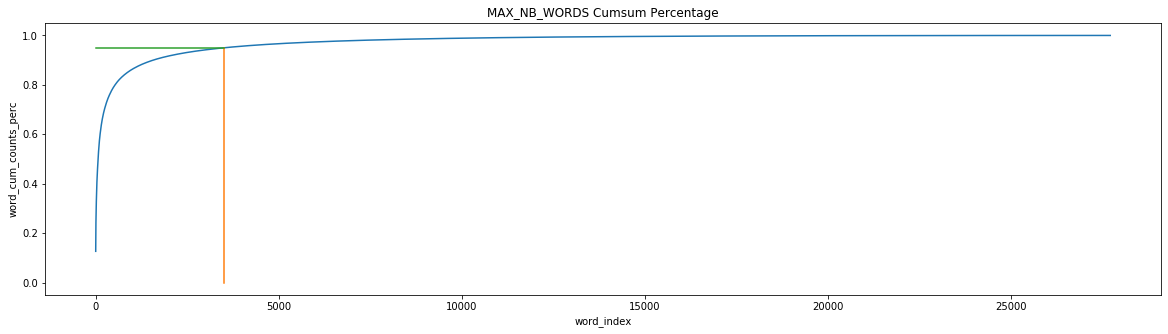

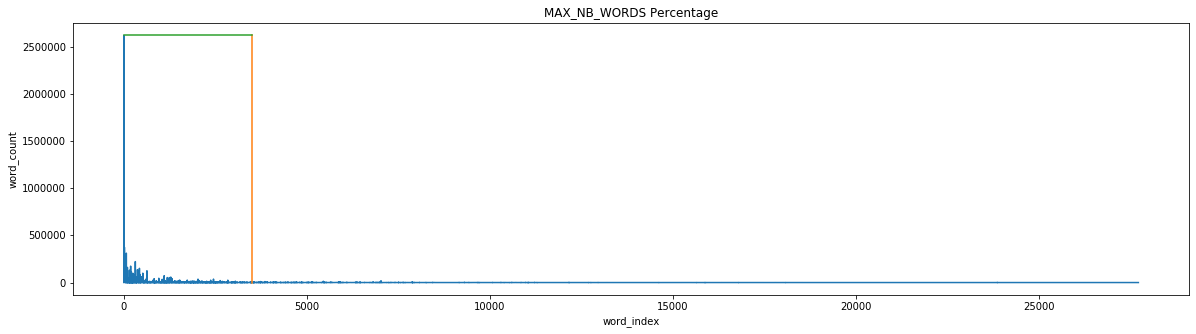

Cut index with 95.0 % of corpus:  3500 

    index   word    count
0       1         2618036
1       4    811   803771
2      10   7717   428966
3      16  17918   374278
4      68  31659   311527
5      19  21935   239950
6      18  15986   238881
7     314  25507   221949
8      25   7202   216950
9      61  18221   182083
10    186  26722   173787
11     98  29347   160453
12    426  16410   150705
13    371   2914   136725
14     35  16129   136115
15     66  11316   132616
16    374  24836   132340
17    154  16110   130922
18    631   9641   124587
19     42   3307   120874


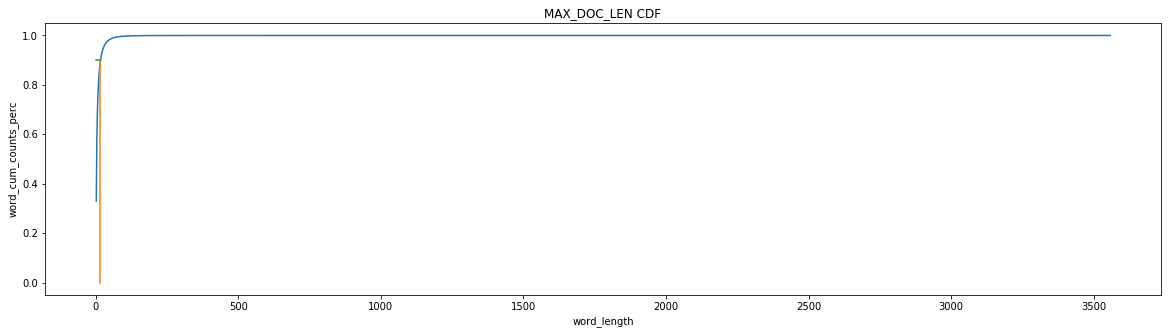

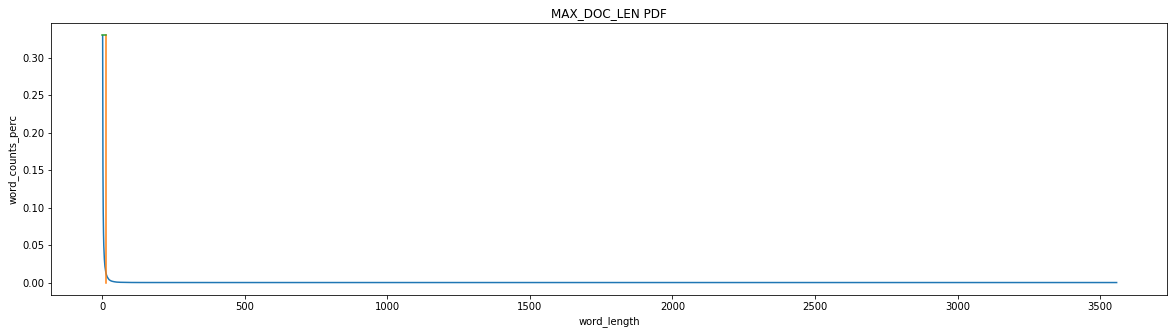

Cut index with 90.0 % of corpus:  15


In [12]:
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.90
char_level_switch = False
MAX_NB_WORDS = eda_MAX_NB_WORDS(corpus, ratio = MAX_NB_WORDS_ratio, filters=' ',char_level = char_level_switch)
MAX_DOC_LEN = eda_MAX_DOC_LEN(corpus, ratio = MAX_DOC_LEN_ratio, filters=' ',char_level = char_level_switch)

## Lots of information are drop
- because most of user doesn't have enough request information 
- with more data, this process will be largely improved

In [13]:
from nltk import ngrams
window_size = int(MAX_DOC_LEN/2) # 80%的样本 request list 的长度, 除以2. 生成对应 n-gram样本. 并以中间为1的为一个样本

def get_samples(tokens, buywhat, window_size): # 比这个短的直接没了
    sku_list = ngrams(tokens, window_size)
    order_list = ngrams(buywhat, window_size)
    n_grams_sku =[]
    for order_grams, sku_grams in zip(order_list, sku_list):
        if order_grams[int(window_size/2)]=='1': # 如果中间这个词为1, 那么周围10个单位, 预测中间这个词 会买
            X = list(sku_grams)
            y = X.pop(int(window_size/2))
            n_grams_sku.append([X, y]) # append([(x), y])
    return n_grams_sku


# get_samples(tokens, buywhat, window_size)

ngram_samples = []
ignore_set=0
for i in list(INFO_Vector):
    tokens = INFO_Vector[i]['seq'].split(',')[0:-1] 
    buywhat =  INFO_Vector[i]['order'].split(',')[0:-1] # 以逗号分隔, 然后去掉最后一个逗号
#     print(tokens,buywhat)
    tmp_sample = get_samples(tokens, buywhat, window_size)
    if len(tmp_sample)>=1: # 如果不为空, 则填入到 training data
        ngram_samples.extend(tmp_sample)
    else:
        ignore_set+=1 # 计数, 丢掉了多少个user信息
        
print("{} user information drop: About ({:.2f}%) ".format(ignore_set, ignore_set/(len(INFO_Vector))*100))

docs = pd.DataFrame(ngram_samples,columns=['X','y'])
docs

2427624 user information drop: About (92.73%) 


,X,y
0,"[9944, 21935, 3723, 30469, 20429, 4867]",30469
1,"[19411, 19411, 13996, 19411, 19411, 19411]",19411
2,"[19411, 13996, 19411, 19411, 19411, 19411]",19411
3,"[13996, 19411, 19411, 19411, 19411, 19411]",19411
4,"[19411, 19411, 19411, 19411, 19411, 11292]",19411
...,...,...
1137897,"[21306, 21306, 21306, 21306, 21306, 21306]",21306
1137898,"[21306, 21306, 21306, 21306, 21306, 21306]",21306
1137899,"[12913, 19013, 19013, 19013, 19013, 19013]",19013
1137900,"[19013, 19013, 19013, 19013, 19013, 19013]",19013


## Split and genarate samples

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# 用sparse categorical loss 就不用对y进行one hot

test_ratio = 0.1
seed=2


x_train,x_test,y_train,y_test = train_test_split(docs['X'],docs['y'],test_size=test_ratio, random_state=seed)
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, docs['X'])

x_train = processor.generate_seq(x_train)
# y_train = to_categorical(y_train)
y_train = y_train.astype(int)
x_test = processor.generate_seq(x_test)
# y_test = to_categorical(y_test)
y_test = y_test.astype(int)
print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))

output_shape = max(y_train)+1 # 为了满足sparse categorical loss的计算



Shape of x_tr: (1024111, 15)
Shape of y_tr: (1024111,)
Shape of x_test: (113791, 15)
Shape of y_test: (113791,)


In [15]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def Best_model_report(grid_result, to_file='GV_result.xlsx' ):
    GV_result = pd.DataFrame(grid_result.cv_results_)
    GV_result.to_excel(to_file)
#     y_pred = grid_result.predict(x_test)
#     y_test_one=np.argmax(y_test,axis=1)
#     cm = confusion_matrix(y_test_one, y_pred)
#     print('confusion matrix:\n', cm)
#     print('classification report:\n', classification_report(y_test_one, y_pred))
    return GV_result

In [16]:
def train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, BestModel_Name="best_model", patience=10 ): # Final one step
    
    #### Best model selection 
    BEST_MODEL_FILEPATH = BestModel_Name
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
    # monitoring
    checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=2)
    model.load_weights(BestModel_Name)

    #### classification Report
    history_plot(history)
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred>0.5))
    scores = model.evaluate(x_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print( "\n\n\n")
    return y_pred # 也许能出 tpr 和 fpr图

In [17]:
# define Model for classification
def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB, NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    q1_input = Input(shape=(MDL,), dtype='int32', name='q1_input') # Hyperparameters: MAX_DOC_LEN
    encode_input1 = cnn_box(q1_input)
    half_features = int(len(FS)*NF/2)
    dense1 = Dense(half_features,activation='relu', name='half_features')(encode_input1)
    drop_1 = Dropout(rate=0.4, name='dropout')(dense1)
    pred = Dense(output_shape,activation='softmax', name='Prediction')(drop_1)
    
    model = Model(inputs=q1_input, outputs=pred)    
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# model = model_Create(FS=[2,3,4], NF=12, EMB=200, MDL=19, MNW=2126, PWV = CBOW_W2V,trainable_switch=False)
# model.fit(x_train, y_train)

## Explaination 
- When predicting, based on user request id sequence, recommend the order sku_id generated by models
- <font color=red> Only need to review the score of the evaluation result for each RNNs</font> The classification report is the CNNs result. I forget to skip it.
- CNNs: 92.80%
- RNNs: 0.807, 0.77538645, 0.7691645

### Pretrained CBOW_W2V for sku_id

In [18]:
EMB = [100]
iter_step= 300
CBOW_W2V =  processor.w2v_pretrain(EMB[0], min_count=2, seed=1, cbow_mean=1,negative=5, window=5, iter=iter_step, workers=3)

## CNNs
- the parameters can be editted into grid search version
- But there is a bug need to be handle later
    - Pretrained embedding cannot be fixed in this code

In [19]:
patience = 10
epoch = 30
n_jobs = 1 # if use GPU, this have to be one.

file_name = 'test'
BestModel_Name = file_name+ 'Best_GS'

############# Set hyper parameters
FILTER_SIZES= [4,5,6,7,8]
NUM_FILTERS=24
EMBEDDING_DIM = 100
BATCH_SIZE=128 # increase speed with large batch size and avoid overfit or wrong direction
NUM_EPOCHES=20 # patience=20
# CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
# Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
OPT = optimizers.Adam(lr=1e-4)
trainable_switch=False


model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, MDL=MAX_DOC_LEN,MNW=MAX_NB_WORDS+1, EMB=EMBEDDING_DIM, PWV = CBOW_W2V, trainable_switch=trainable_switch, optimizer=OPT )
# model_best_1_pred = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, BestModel_Name=BestModel_Name)
# model.fit(x_train, y_train)

In [20]:
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
# monitoring
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=2)
model.load_weights(BestModel_Name)

Train on 819288 samples, validate on 204823 samples
Epoch 1/20
819288/819288 - 331s - loss: 2.5701 - acc: 0.6402 - val_loss: 0.8164 - val_acc: 0.8797
Epoch 2/20
819288/819288 - 330s - loss: 0.8964 - acc: 0.8562 - val_loss: 0.5071 - val_acc: 0.9116
Epoch 3/20
819288/819288 - 331s - loss: 0.6618 - acc: 0.8833 - val_loss: 0.4407 - val_acc: 0.9211
Epoch 4/20
819288/819288 - 334s - loss: 0.5774 - acc: 0.8939 - val_loss: 0.4167 - val_acc: 0.9239
Epoch 5/20
819288/819288 - 343s - loss: 0.5343 - acc: 0.8991 - val_loss: 0.4089 - val_acc: 0.9252
Epoch 6/20
819288/819288 - 354s - loss: 0.5059 - acc: 0.9027 - val_loss: 0.4052 - val_acc: 0.9259
Epoch 7/20
819288/819288 - 363s - loss: 0.4859 - acc: 0.9050 - val_loss: 0.4011 - val_acc: 0.9260
Epoch 8/20
819288/819288 - 370s - loss: 0.4708 - acc: 0.9064 - val_loss: 0.3970 - val_acc: 0.9269
Epoch 9/20
819288/819288 - 378s - loss: 0.4586 - acc: 0.9079 - val_loss: 0.4018 - val_acc: 0.9271
Epoch 10/20
819288/819288 - 384s - loss: 0.4477 - acc: 0.9086 - va

loss val_loss


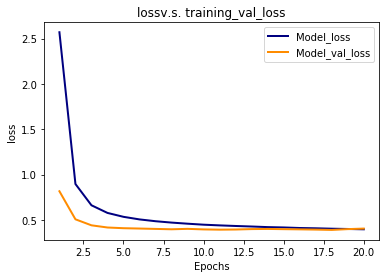

acc val_acc


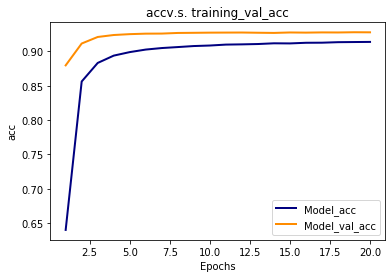

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.93      0.96      0.94        26
          21       0.00      0.00      0.00         2
          28       1.00      1.00      1.00         2
          31       1.00      1.00      1.00         1
          44       1.00      1.00      1.00         2
          51       0.93      0.88      0.90       104
          61       0.00      0.00      0.00         1
          64       0.80      1.00      0.89         4
          78       1.00      1.00      1.00         2
         112       0.91      0.95      0.93        42
         114       0.92      0.81      0.86        27
         121       0.00      0.00      0.00         1
         128       1.00      1.00      1.00         1
         131       1.00      1.00      1.00         4
         132       0.50      1.00      0.67         1
         137       0.92    

In [21]:
#### classification Report
history_plot(history)
y_pred = model.predict(x_test)
print(classification_report(y_test, np.argmax(y_pred, axis=1)))
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

## RNN

In [22]:
# rnn_dt_train =  pd.read_pickle('rnn_dt_train.pkl')
# # num_samples= 10000000

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# 用sparse categorical loss 就不用对y进行one hot

test_ratio = 0.1
seed=2


x_train,x_test,y_train,y_test = train_test_split(docs['X'],docs['y'],test_size=test_ratio, random_state=seed)
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, docs['X'])

x_train = processor.generate_seq(x_train)
# y_train = to_categorical(y_train)
y_train = y_train.astype(int)
x_test = processor.generate_seq(x_test)
# y_test = to_categorical(y_test)
y_test = y_test.astype(int)
print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))

output_shape = max(y_train)+1 # 为了满足sparse categorical loss的计算



Shape of x_tr: (1024111, 15)
Shape of y_tr: (1024111,)
Shape of x_test: (113791, 15)
Shape of y_test: (113791,)


In [23]:
print("MAX_DOC_LEN", MAX_DOC_LEN)
print("MAX_NB_WORDS", MAX_NB_WORDS)
docs

MAX_DOC_LEN 15
MAX_NB_WORDS 3500


,X,y
0,"[9944, 21935, 3723, 30469, 20429, 4867]",30469
1,"[19411, 19411, 13996, 19411, 19411, 19411]",19411
2,"[19411, 13996, 19411, 19411, 19411, 19411]",19411
3,"[13996, 19411, 19411, 19411, 19411, 19411]",19411
4,"[19411, 19411, 19411, 19411, 19411, 11292]",19411
...,...,...
1137897,"[21306, 21306, 21306, 21306, 21306, 21306]",21306
1137898,"[21306, 21306, 21306, 21306, 21306, 21306]",21306
1137899,"[12913, 19013, 19013, 19013, 19013, 19013]",19013
1137900,"[19013, 19013, 19013, 19013, 19013, 19013]",19013


In [24]:
MAX_NB_WORDS

3500

In [25]:
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

latent_dim = 32
EMBEDDING_DIM = 100

### construct the RNN with GRU unit
model_0 = Sequential()
model_0.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM)) #  embedding dimension , 这里的输入应该是 one-hot 的19个词. 还是直接sequence. 都行
model_0.add(LSTM(latent_dim, dropout=0.0, recurrent_dropout=0.5,return_sequences=True))
model_0.add(LSTM(latent_dim, dropout=0.0, recurrent_dropout=0.5,return_sequences=True))
model_0.add(LSTM(latent_dim, dropout=0.0, recurrent_dropout=0.5,return_sequences=False))
model_0.add(Dropout(0.4))
model_0.add(Dense(output_shape, activation='softmax')) # 因为 y 是经过 one-hot 的, 所以他能保存位置信息.

model_0.summary()
model_0.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model_0.fit(x_train, y_train, epochs=10,  batch_size=128, validation_split=0.1,  shuffle=True) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         350000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          17024     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32193)             1062369   
Total params: 1,446,033
Trainable params: 1,446,033
Non-trainable params: 0
______________________________________________

loss val_loss


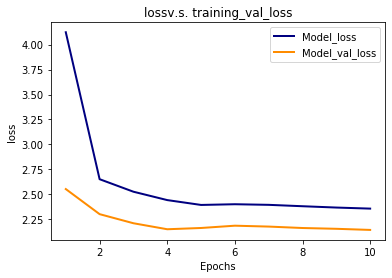

sparse_categorical_accuracy val_sparse_categorical_accuracy


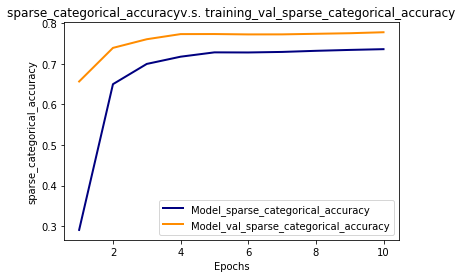

In [28]:
#### classification Report
history_plot(history)
# y_pred = model.predict(x_test) # 内存不够
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
scores = model_0.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")
scores

### Inverse encoding

In [31]:
RNN_recommend_result =[] 

for seq in tqdm(x_test):
    sku_record = []
    for i in seq:
        sku_record.append(processor.index_word[i]) # 返回商品顺序
    idx = np.argmax(model.predict(seq.reshape(1,-1)),axis=1)[0] # 找到最大概率的商品
    sku_record.append(idx)
    RNN_recommend_result.append(sku_record)
    
RNN_recommend_result = pd.DataFrame(RNN_recommend_result)
RNN_recommend_result.columns = list(RNN_recommend_result.columns[0:-1])+['recommend']
RNN_recommend_result

100%|█████████████████████████████████████████████████████████████████████████| 113791/113791 [13:32<00:00, 140.03it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,recommend
0,11523,11523,11523,11523,11523,2391,_,_,_,_,_,_,_,_,_,17918
1,30794,30794,30794,30794,30794,30794,_,_,_,_,_,_,_,_,_,30794
2,27209,27209,16910,16910,16910,16910,_,_,_,_,_,_,_,_,_,16910
3,7202,7202,7202,7202,7202,7202,_,_,_,_,_,_,_,_,_,7202
4,17356,17356,17356,17356,17356,17356,_,_,_,_,_,_,_,_,_,17356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113786,9641,9641,9641,9641,9641,9641,_,_,_,_,_,_,_,_,_,9641
113787,8319,8319,8319,8319,21935,6900,_,_,_,_,_,_,_,_,_,8319
113788,30632,18200,18710,18710,21323,11316,_,_,_,_,_,_,_,_,_,18710
113789,14610,14610,14610,14610,14610,14610,_,_,_,_,_,_,_,_,_,14610


## Other RNNs

loss val_loss


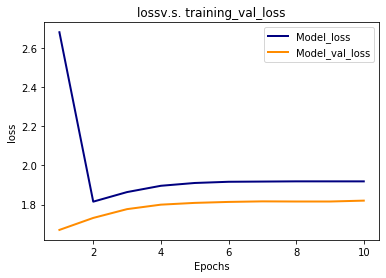

sparse_categorical_accuracy val_sparse_categorical_accuracy


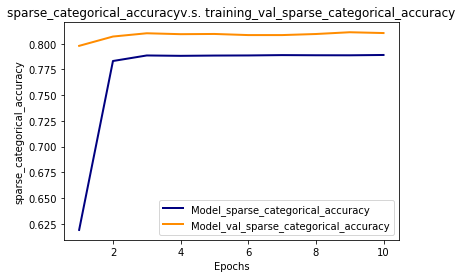

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.93      0.96      0.94        26
          21       0.00      0.00      0.00         2
          28       1.00      1.00      1.00         2
          31       1.00      1.00      1.00         1
          44       1.00      1.00      1.00         2
          51       0.93      0.88      0.90       104
          61       0.00      0.00      0.00         1
          64       0.80      1.00      0.89         4
          78       1.00      1.00      1.00         2
         112       0.91      0.95      0.93        42
         114       0.92      0.81      0.86        27
         121       0.00      0.00      0.00         1
         128       1.00      1.00      1.00         1
         131       1.00      1.00      1.00         4
         132       0.50      1.00      0.67         1
         137       0.92    

[1.845661366541945, 0.80693555]

In [39]:
### construct the RNN with GRU unit
model_1 = Sequential()
model_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM)) #  embedding dimension , 这里的输入应该是 one-hot 的19个词. 还是直接sequence. 都行
model_1.add(Bidirectional(LSTM(latent_dim, dropout=0.0, recurrent_dropout=0.2,return_sequences=False)))
model_1.add(Dropout(0.4))
model_1.add(Dense(output_shape, activation='softmax')) # 因为 y 是经过 one-hot 的, 所以他能保存位置信息.

model_1.summary()
model_1.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model_1.fit(x_train, y_train, epochs=10,  batch_size=128, validation_split=0.1,  shuffle=True) 


#### classification Report
history_plot(history)
# y_pred = model_1.predict(x_test) # 内存不够
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
scores = model_1.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_1.metrics_names[1], scores[1]*100))
print( "\n\n\n")
scores

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         350000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32193)             1062369   
Total params: 1,429,393
Trainable params: 1,429,393
Non-trainable params: 0
_________________________________________________________________
Train on 921699 samples, validate on 102412 samples
Epoch 1/10
921699/921699 [==============================] - 366s 397us/sample - loss: 3.4818 - sparse_categorical_accuracy: 0.4731 - val_loss: 2.0153 - val_sparse_categorical_accuracy: 0.755

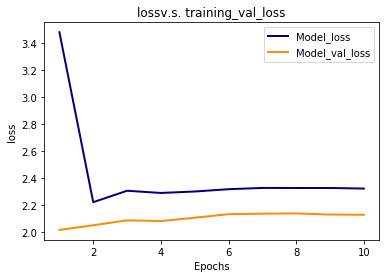

sparse_categorical_accuracy val_sparse_categorical_accuracy


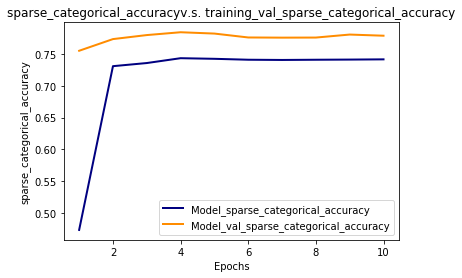

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.93      0.96      0.94        26
          21       0.00      0.00      0.00         2
          28       1.00      1.00      1.00         2
          31       1.00      1.00      1.00         1
          44       1.00      1.00      1.00         2
          51       0.93      0.88      0.90       104
          61       0.00      0.00      0.00         1
          64       0.80      1.00      0.89         4
          78       1.00      1.00      1.00         2
         112       0.91      0.95      0.93        42
         114       0.92      0.81      0.86        27
         121       0.00      0.00      0.00         1
         128       1.00      1.00      1.00         1
         131       1.00      1.00      1.00         4
         132       0.50      1.00      0.67         1
         137       0.92    

[2.15774123664124, 0.77538645]

In [40]:
### construct the RNN with GRU unit
model_2 = Sequential()
model_2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM)) #  embedding dimension , 这里的输入应该是 one-hot 的19个词. 还是直接sequence. 都行
model_2.add((LSTM(latent_dim, dropout=0.0, recurrent_dropout=0.2,return_sequences=False)))
model_2.add(Dropout(0.4))
model_2.add(Dense(output_shape, activation='softmax')) # 因为 y 是经过 one-hot 的, 所以他能保存位置信息.

model_2.summary()
model_2.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model_2.fit(x_train, y_train, epochs=10,  batch_size=128, validation_split=0.1,  shuffle=True) 

#### classification Report
history_plot(history)
# y_pred = model_2.predict(x_test) # 内存不够
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
scores = model_2.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_2.metrics_names[1], scores[1]*100))
print( "\n\n\n")
scores

loss val_loss


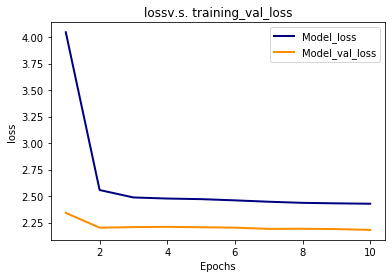

sparse_categorical_accuracy val_sparse_categorical_accuracy


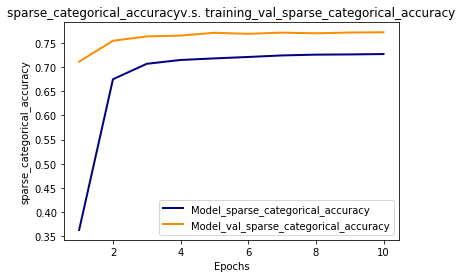

113791/113791 - 40s - loss: 2.2056 - sparse_categorical_accuracy: 0.7692
sparse_categorical_accuracy: 76.92%






[2.2056044855089385, 0.7691645]

In [43]:
### construct the RNN with GRU unit
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM)) #  embedding dimension , 这里的输入应该是 one-hot 的19个词. 还是直接sequence. 都行
model_3.add((GRU(latent_dim, dropout=0.0, recurrent_dropout=0.2,return_sequences=False)))
model_3.add(Dropout(0.4))
model_3.add(Dense(output_shape, activation='softmax')) # 因为 y 是经过 one-hot 的, 所以他能保存位置信息.

model_3.summary()
model_3.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
history = model_3.fit(x_train, y_train, epochs=10,  batch_size=128, validation_split=0.1,  shuffle=True) 



#### classification Report
history_plot(history)
# y_pred = model_3.predict(x_test) # 内存不够
# print(classification_report(y_test, np.argmax(y_pred, axis=1)))
scores = model_3.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_3.metrics_names[1], scores[1]*100))
print( "\n\n\n")
scores

# Other EDA - Tableau could handle

## Pie - platform distributionm
- Color map: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

In [ ]:
PATH_CLICK = './data/JD_click_data.csv'
PATH_USER = './data/JD_user_data.csv'
PATH_SKU = './data/JD_sku_data.csv'
PATH_ORDER = './data/JD_order_data.csv'

In [ ]:
import pandas as pd
order_table = pd.read_csv('order_table.csv',nrows=100000)
# order_table.to_csv('order_table_tmp.csv')
# order_table.to_csv('order_table.csv')

In [ ]:
click_table = pd.read_csv('click_table.csv',nrows=100000)
# click_table.to_csv('click_table_tmp.csv')

In [ ]:
click_table.columns

In [ ]:
import matplotlib.pyplot as plt
df_3 = click_table.groupby(['channel']).count()
df_3.iloc[:,0].plot(
    kind='pie',
    table=df_3.iloc[:,1],
    autopct='%1.1f%%', cmap='Set3',figsize=(8,8)
)

# View the plot
plt.tight_layout()
plt.show()